In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import GPy, patsy, scipy

In [4]:
od = pd.read_excel("data/cfu-od-raw.xlsx")
od

,strain,0,17,22,25,31,38,44,47,50.5,64.5,94.5
0,ura3_A,0.007,0.020,0.030,0.046,0.116,0.249,0.489,0.598,0.814,1.71,1.91
1,ura3_B,0.007,0.023,0.040,0.061,0.128,0.261,0.477,0.580,0.721,1.70,1.73
2,ura3_C,0.007,0.020,0.044,0.052,0.124,0.259,0.482,0.606,0.823,1.78,2.62
3,0195_A,0.006,0.012,0.022,0.033,0.079,0.172,0.354,0.455,0.620,1.52,2.11
4,0195_B,0.007,0.019,0.036,0.043,0.101,0.212,0.409,0.542,0.699,1.71,2.25
5,0195_C,0.010,0.017,0.027,0.037,0.095,0.212,0.407,0.549,0.731,1.71,2.30
6,0194_A,0.006,0.018,0.032,0.043,0.093,0.191,0.357,0.469,0.608,1.71,2.36
7,0194_B,0.007,0.039,0.069,0.108,0.233,0.468,0.761,0.980,1.190,1.62,1.84
8,0194_C,0.009,0.034,0.061,0.095,0.199,0.419,0.645,0.870,0.970,1.78,2.06
9,ftsZ2_A,0.008,0.019,0.030,0.049,0.119,0.244,0.469,0.568,0.742,1.40,2.17


In [5]:
melt = pd.melt(od,id_vars=['strain'],var_name='time', value_name='OD600')
melt.head()

,strain,time,OD600
0,ura3_A,0,0.007
1,ura3_B,0,0.007
2,ura3_C,0,0.007
3,0195_A,0,0.006
4,0195_B,0,0.007


In [6]:
cfu = pd.read_excel("data/cfu-od-raw.xlsx",sheetname=1)
cfu

,strain,OD600,CFUs/ml
0,ura3_A,0.249,100000000
1,ura3_A,0.814,280000000
2,ura3_A,1.710,600000000
3,ura3_A,1.910,2000000000
4,ura3_B,0.261,80000000
5,ura3_B,0.721,400000000
6,ura3_B,1.700,800000000
7,ura3_B,1.730,320000000
8,ura3_C,0.259,120000000
9,ura3_C,0.823,400000000


In [453]:
merge = pd.merge(melt, cfu, 'outer', ['strain', 'OD600'])
# merge = pd.merge(melt, cfu, 'inner', ['strain', 'OD600'])

merge['logCFU'] = np.log10(merge['CFUs/ml'])
merge['logOD'] = np.log2(merge.OD600)
merge.time = merge.time.astype(float)
merge['normtime'] = (merge.time-merge.time.mean())/merge.time.std()

merge.head()

,strain,time,OD600,CFUs/ml,logCFU,logOD,normtime
0,ura3_A,0.0,0.007,NaN,NaN,-7.158429,-1.614436
1,ura3_B,0.0,0.007,NaN,NaN,-7.158429,-1.614436
2,ura3_C,0.0,0.007,NaN,NaN,-7.158429,-1.614436
3,0195_A,0.0,0.006,NaN,NaN,-7.380822,-1.614436
4,0195_B,0.0,0.007,NaN,NaN,-7.158429,-1.614436


In [454]:
merge.tail()

,strain,time,OD600,CFUs/ml,logCFU,logOD,normtime
127,0194_B,94.5,1.84,200000000.0,8.301030,0.879706,2.256859
128,0194_C,94.5,2.06,400000000.0,8.602060,1.042644,2.256859
129,ftsZ2_A,94.5,2.17,320000000.0,8.505150,1.117695,2.256859
130,ftsZ2_B,94.5,2.07,260000000.0,8.414973,1.049631,2.256859
131,ftsZ2_C,94.5,1.91,260000000.0,8.414973,0.933573,2.256859


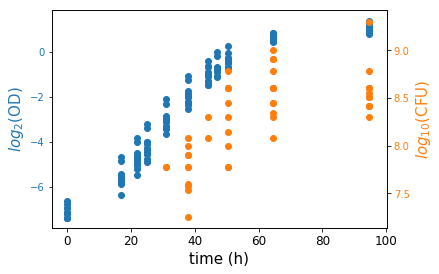

In [455]:
plt.figure(figsize=(6,4))

plt.scatter(merge.time, merge.logOD,c='C0')
plt.ylabel("$log_2($OD$)$",fontsize=15,color='C0')
plt.yticks(color='C0')
plt.xticks(fontsize=12)
plt.xlabel("time (h)", fontsize=15)

plt.twinx()
plt.scatter(merge.time, merge.logCFU,c='C1')
plt.ylabel("$log_{10}($CFU$)$",fontsize=15,color='C1')
plt.yticks(color='C1')

plt.savefig("figures/cfu-vs-od.pdf",bbox_inches='tight')

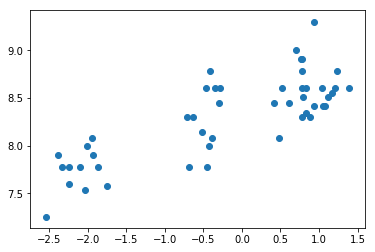

In [314]:
plt.scatter(merge.logOD, merge.logCFU)

In [313]:
merge.head()

,strain,time,OD600,CFUs/ml,logCFU,logOD,normtime
0,ura3_A,0.0,0.007,NaN,NaN,-7.158429,-1.614436
1,ura3_B,0.0,0.007,NaN,NaN,-7.158429,-1.614436
2,ura3_C,0.0,0.007,NaN,NaN,-7.158429,-1.614436
3,0195_A,0.0,0.006,NaN,NaN,-7.380822,-1.614436
4,0195_B,0.0,0.007,NaN,NaN,-7.158429,-1.614436


In [384]:
# y1,x1 = patsy.dmatrices('standardize(logOD) ~ standardize(time) + 0', merge)

# x2 = patsy.build_design_matrices([x1.design_info], merge[~merge.logCFU.isnull()])[0]
# y2 = patsy.dmatrix('standardize(logCFU) + 0', merge[~merge.logCFU.isnull()])
# # y2,x2 = patsy.dmatrices('standardize(logCFU) ~ standardize(time) + 0', merge[~merge.logCFU.isnull()])

# x1.shape, y1.shape, x2.shape, y2.shape

((132, 1), (132, 1), (48, 1), (48, 1))

In [392]:
# k = y1.design_info.factor_infos.keys()[0]
# fi = y1.design_info.factor_infos[k]
# st = fi.state['transforms']['_patsy_stobj0__standardize__']

# st.current_mean, st.current_M2

In [441]:
x1 = merge.normtime.values[:,None]
y1 = merge.logOD.values[:,None]

x2 = merge.normtime.values[~merge.logCFU.isnull(),None]
y2 = merge.logCFU.values[~merge.logCFU.isnull(),None]
# x2 = merge.normtime.values[:,None]
# y2 = merge.logCFU.values[:,None]

norm = {'y1': (y1.mean(), y1.std()),\
        'y2': (y2.mean(), y2.std()),\
        'time': (merge.time.mean(), merge.time.std())}

y1 = (y1-y1.mean())/y1.std()
y2 = (y2-y2.mean())/y2.std()

x1.shape, y1.shape, x2.shape, y2.shape,

((132, 1), (132, 1), (48, 1), (48, 1))

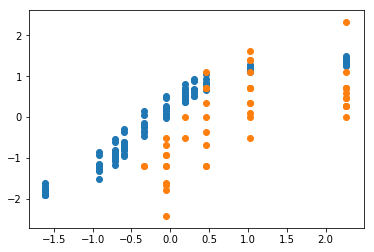

In [389]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)

In [460]:
lcm = GPy.util.multioutput.LCM(1,1,[GPy.kern.RBF(1) for i in range(2)])

In [461]:
lcm

sum.,value,constraints,priors
ICM0.rbf.variance,1.0,+ve,
ICM0.rbf.lengthscale,1.0,+ve,
ICM0.B.W,[ 0.2959335],,
ICM0.B.kappa,0.5,+ve,
ICM1.rbf.variance,1.0,+ve,
ICM1.rbf.lengthscale,1.0,+ve,
ICM1.B.W,[ 0.35927787],,
ICM1.B.kappa,0.5,+ve,


In [462]:
lcm.ICM0.B

B.,value,constraints,priors
W,[ 0.2959335],,
kappa,0.5,+ve,


In [494]:
K = GPy.kern.Matern32(1)
# K = GPy.kern.Matern52(1)
kern = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=K,W_rank=2)

# kern = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[GPy.kern.Matern32(1) for i in range(2)])

m = GPy.models.GPCoregionalizedRegression([x1,x2],[y1,y2],kernel=kern)
m['.*Mat.*.var'].constrain_fixed(1.)

# icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.RBF(1))
# m = GPy.models.GPCoregionalizedRegression([x1,x2],[y1,y2],kernel=icm)
# m.kern.rbf.variance.constrain_fixed(1.)

m.randomize()
m.optimize()
m

gp.,value,constraints,priors
ICM.Mat32.variance,1.0,fixed +ve,
ICM.Mat32.lengthscale,6.46633883733,+ve,
ICM.B.W,"(2, 2)",,
ICM.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.0191460330308,+ve,
mixed_noise.Gaussian_noise_1.variance,0.426411569426,+ve,


In [495]:
# kern.ICM0.B.W

In [496]:
# kern.ICM0.B.kappa

In [497]:
# kern.ICM1.B.W

In [498]:
# kern.ICM1.B.kappa

In [499]:
# kern.B.W

In [500]:
# icm.B.kappa

In [501]:
icm.B.B[1,0]/np.sqrt(icm.B.B[0,0])/np.sqrt(icm.B.B[1,1])

0.97361024280868436

In [502]:
def reverseTransform(z, mean, std):
    return z*std + mean

In [554]:
def plotPrediction(xpred, predict_func, n, **kwargs):
    noise_dict = {'output_index':xpred[:,1:].astype(int)}
    mu, var = predict_func(xpred,Y_metadata=noise_dict)
    std = np.sqrt(var[:,0])
    mu = mu[:,0]

    plt.plot(reverseTransform(xpred[:,0],*norm['time']), reverseTransform(mu, *n), **kwargs)
    plt.fill_between(reverseTransform(xpred[:,0],*norm['time']), reverseTransform(mu-1.98*std, *n), reverseTransform(mu+1.98*std, *n), alpha=.2, **kwargs)

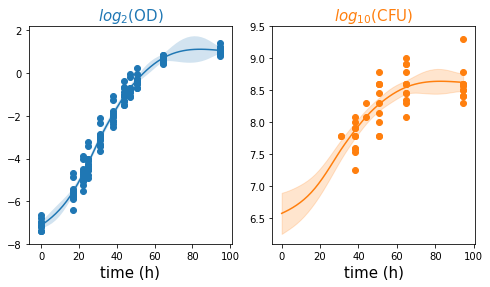

In [555]:
plt.figure(figsize=(8,4))

xpred = np.hstack([np.linspace(x1.min(), x1.max())[:,None], [[0]]*50])

plt.subplot(121)
plt.title("$log_2($OD$)$",fontsize=15,color='C0')
plt.xlabel("time (h)", fontsize=15)
plotPrediction(xpred, m.predict_noiseless, norm['y1'])
plt.scatter(reverseTransform(x1, *norm['time']), reverseTransform(y1[:,0],*norm['y1']),c='C0')

plt.subplot(122)
plt.title("$log_{10}($CFU$)$",fontsize=15,color='C1')
plt.xlabel("time (h)", fontsize=15)
xpred[:,1] = 1
plotPrediction(xpred, m.predict_noiseless, norm['y2'],color='C1')
plt.scatter(reverseTransform(x2, *norm['time']), reverseTransform(y2[:,0],*norm['y2']),c='C1')

plt.savefig("figures/cfu-vs-od_gp.pdf",bbox_inches='tight')

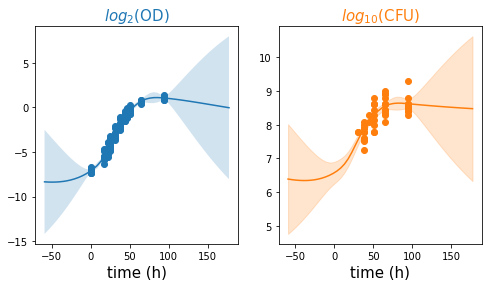

In [556]:
plt.figure(figsize=(8,4))

xpred = np.hstack([np.linspace(x1.min()*2.5, x1.max()*2.5)[:,None], [[0]]*50])

plt.subplot(121)
plt.title("$log_2($OD$)$",fontsize=15,color='C0')
plt.xlabel("time (h)", fontsize=15)
plotPrediction(xpred, m.predict_noiseless, norm['y1'])
plt.scatter(reverseTransform(x1, *norm['time']), reverseTransform(y1[:,0],*norm['y1']),c='C0')

plt.subplot(122)
plt.title("$log_{10}($CFU$)$",fontsize=15,color='C1')
plt.xlabel("time (h)", fontsize=15)
xpred[:,1] = 1
plotPrediction(xpred, m.predict_noiseless, norm['y2'],color='C1')
plt.scatter(reverseTransform(x2, *norm['time']), reverseTransform(y2[:,0],*norm['y2']),c='C1')

plt.savefig("figures/cfu-vs-od-long_gp.pdf",bbox_inches='tight')

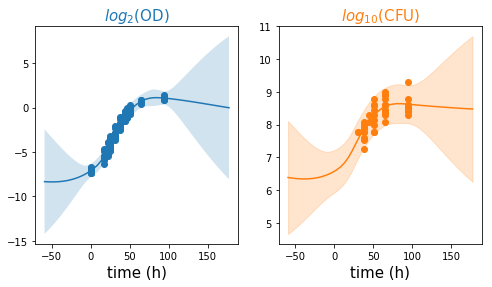

In [560]:
plt.figure(figsize=(8,4))

xpred = np.hstack([np.linspace(x1.min()*2.5, x1.max()*2.5)[:,None], [[0]]*50])

plt.subplot(121)
plt.title("$log_2($OD$)$",fontsize=15,color='C0')
plt.xlabel("time (h)", fontsize=15)
plotPrediction(xpred, m.predict, norm['y1'])
plt.scatter(reverseTransform(x1, *norm['time']), reverseTransform(y1[:,0],*norm['y1']),c='C0')

plt.subplot(122)
plt.title("$log_{10}($CFU$)$",fontsize=15,color='C1')
plt.xlabel("time (h)", fontsize=15)
xpred[:,1] = 1
plotPrediction(xpred, m.predict, norm['y2'],color='C1')
plt.scatter(reverseTransform(x2, *norm['time']), reverseTransform(y2[:,0],*norm['y2']),c='C1')

plt.savefig("figures/cfu-vs-od-obs-long_gp.pdf",bbox_inches='tight')

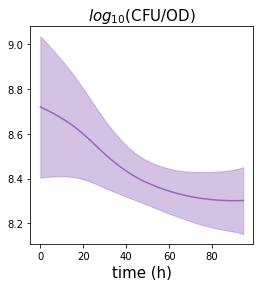

In [543]:
xpred = np.hstack([np.tile(np.linspace(x1.min(), x1.max()),2)[:,None], [[0]]*100])
xpred[50:,1] = 1
noise_dict = {'output_index':xpred[:,1:].astype(int)}
mu, cov = m.predict_noiseless(xpred,Y_metadata=noise_dict,full_cov=True)
mu = mu[:,0]

# y = Bx + c
B = np.zeros((100,100))
B[range(100),range(100)] = [norm['y1'][1]]*50 + [norm['y2'][1]]*50

c = np.zeros(100)
c[:50] = norm['y1'][0]
c[50:] = norm['y2'][0]

mu = np.dot(B, mu) + c
cov = np.dot(B, np.dot(cov, B.T))


B = np.eye(100)
# convert cfu to log2
# B[range(50,100),range(50,100)] = 1./np.log10(2)
# ..or convert OD to log10
B[range(50),range(50)] = 1./np.log2(10)

mu = np.dot(B, mu)
cov = np.dot(B, np.dot(cov, B.T))

# compute diff
B = np.zeros((50,100))
B[range(50),range(50)] = -1.
B[range(50),range(50,100)] = 1.

mu = np.dot(B, mu)
cov = np.dot(B, np.dot(cov, B.T))
std = np.sqrt(np.diag(cov))

plt.figure(figsize=(4,4))

plt.plot(reverseTransform(xpred[:50,0],*norm['time']), mu, color='C4')
plt.fill_between(reverseTransform(xpred[:50,0],*norm['time']), mu-1.98*std, mu+1.98*std,alpha=.4, color='C4')

plt.title("$log_{10}($CFU/OD$)$",fontsize=15)
plt.xlabel("time (h)", fontsize=15)

plt.savefig("figures/cfu-vs-od_gp-ratio.pdf",bbox_inches='tight')

In [328]:
K = GPy.kern.Matern32(1)

m1 = GPy.models.GPRegression(x1,y1,kernel=K.copy())
m1.optimize()
m2 = GPy.models.GPRegression(x2,y2,kernel=K.copy())
m2.optimize()

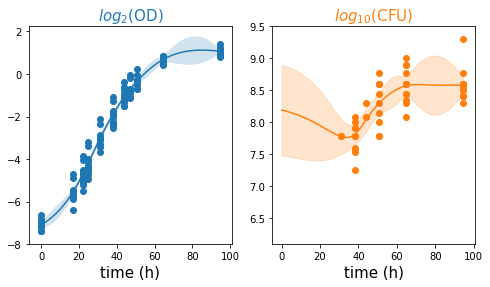

In [557]:
plt.figure(figsize=(8,4))

xpred = np.hstack([np.linspace(x1.min(), x1.max())[:,None], [[0]]*50])

plt.subplot(121)
plt.title("$log_2($OD$)$",fontsize=15,color='C0')
plt.xlabel("time (h)", fontsize=15)
plotPrediction(xpred, m1.predict_noiseless, norm['y1'])
plt.scatter(reverseTransform(x1, *norm['time']), reverseTransform(y1[:,0],*norm['y1']),c='C0')

plt.subplot(122)
plt.title("$log_{10}($CFU$)$",fontsize=15,color='C1')
plt.xlabel("time (h)", fontsize=15)
xpred[:,1] = 1
plotPrediction(xpred, m2.predict_noiseless, norm['y2'],color='C1')
plt.scatter(reverseTransform(x2, *norm['time']), reverseTransform(y2[:,0],*norm['y2']),c='C1')
plt.ylim(6.1, 9.5)

plt.savefig("figures/cfu-vs-od_gp-null.pdf")

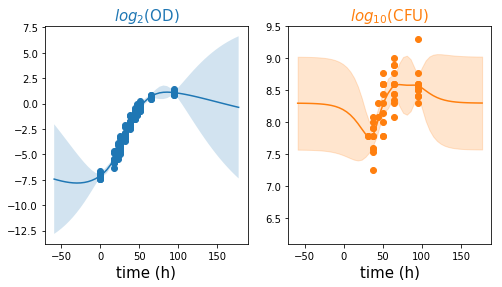

In [558]:
plt.figure(figsize=(8,4))

xpred = np.hstack([np.linspace(x1.min()*2.5, x1.max()*2.5)[:,None], [[0]]*50])

plt.subplot(121)
plt.title("$log_2($OD$)$",fontsize=15,color='C0')
plt.xlabel("time (h)", fontsize=15)
plotPrediction(xpred, m1.predict_noiseless, norm['y1'])
plt.scatter(reverseTransform(x1, *norm['time']), reverseTransform(y1[:,0],*norm['y1']),c='C0')

plt.subplot(122)
plt.title("$log_{10}($CFU$)$",fontsize=15,color='C1')
plt.xlabel("time (h)", fontsize=15)
xpred[:,1] = 1
plotPrediction(xpred, m2.predict_noiseless, norm['y2'],color='C1')
plt.scatter(reverseTransform(x2, *norm['time']), reverseTransform(y2[:,0],*norm['y2']),c='C1')
plt.ylim(6.1, 9.5)

plt.savefig("figures/cfu-vs-od-long_gp-null.pdf",bbox_inches='tight')